#Importing Libraries

In [ ]:
!pip install beir
!pip install sentence-transformers

#Downloading FiQA Datset

In [2]:
from beir.datasets.data_loader import GenericDataLoader
from beir import util

dataset = "fiqa"
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip"

data_path = util.download_and_unzip(url, "datasets")


corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

all_questions = list(queries.values())
all_answers = [doc_info["text"] for doc_info in corpus.values()]

/usr/local/lib/python3.10/dist-packages/beir/datasets/data_loader.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


datasets/fiqa.zip:   0%|          | 0.00/17.1M [00:00<?, ?iB/s]

  0%|          | 0/57638 [00:00<?, ?it/s]

In [3]:
all_questions[0]

'How to deposit a cheque issued to an associate in my business into my business account?'

In [4]:
all_answers[0]

"I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything."

#Initialising Embedding Model

In [31]:
from sentence_transformers import SentenceTransformer


small_model = SentenceTransformer('all-MiniLM-L6-v2')
large_model = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-v4')

#Converting Answers to Embeddings

In [7]:
all_answers_embeddings_small = small_model.encode(all_answers, device='cuda')

In [34]:
all_answers_embeddings_large = large_model.encode(all_answers, device='cuda')

In [9]:
question  ="How to deposit a cheque issued to an associate in my business into my business account?"

In [10]:
ques_embedding_small = small_model.encode(question, device='cuda')

In [11]:
ques_embedding_large = large_model.encode(question, device='cuda')

#Finding relevant passages


In [12]:
import numpy as np

def get_most_similar_answers(question_embedding, answer_embeddings, answer_strings,top_k):

    def cosine_similarity(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

    similarity_scores = [cosine_similarity(question_embedding, answer_embedding) for answer_embedding in answer_embeddings]

    top_indices = np.argsort(similarity_scores)[-top_k:][::-1]
    top_answers = [answer_strings[i] for i in top_indices]

    return top_answers

In [13]:
similar_answers = get_most_similar_answers(ques_embedding_small,all_answers_embeddings_small,all_answers,5)

In [14]:
for i in similar_answers:
  print(i,'\n')

Just have the associate sign the back and then deposit it.  It's called a third party cheque and is perfectly legal.  I wouldn't be surprised if it has a longer hold period and, as always, you don't get the money if the cheque doesn't clear. Now, you may have problems if it's a large amount or you're not very well known at the bank.  In that case you can have the associate go to the bank and endorse it in front of the teller with some ID.  You don't even technically have to be there.  Anybody can deposit money to your account if they have the account number. He could also just deposit it in his account and write a cheque to the business. 

"I have checked with Bank of America, and they say the ONLY way to cash (or deposit, or otherwise get access to the funds represented by a check made out to my business) is to open a business account. They tell me this is a Federal regulation, and every bank will say the same thing.  To do this, I need a state-issued ""dba"" certificate (from the cou

#Reranking Passages


In [15]:
from sentence_transformers import CrossEncoder

def rerank_docs(query, docs, model_name):

    reranker = CrossEncoder(model_name,device = 'cuda')
    pairs = [(query, doc) for doc in docs]
    scores = reranker.predict(pairs)

    ranked_docs = [doc for _, doc in sorted(zip(scores, docs), reverse=True)]

    return ranked_docs

In [17]:
reranked_results = rerank_docs(question,similar_answers,model_name = 'BAAI/bge-reranker-large')

In [18]:
for i in reranked_results:
  print(i,'\n')

Just have the associate sign the back and then deposit it.  It's called a third party cheque and is perfectly legal.  I wouldn't be surprised if it has a longer hold period and, as always, you don't get the money if the cheque doesn't clear. Now, you may have problems if it's a large amount or you're not very well known at the bank.  In that case you can have the associate go to the bank and endorse it in front of the teller with some ID.  You don't even technically have to be there.  Anybody can deposit money to your account if they have the account number. He could also just deposit it in his account and write a cheque to the business. 

"I have checked with Bank of America, and they say the ONLY way to cash (or deposit, or otherwise get access to the funds represented by a check made out to my business) is to open a business account. They tell me this is a Federal regulation, and every bank will say the same thing.  To do this, I need a state-issued ""dba"" certificate (from the cou

##Getting already known passages from dataset

In [20]:
def get_relevant_passages(index):
    query_id = list(queries.keys())[index]  # Get the first query as an example
    query_text = queries[query_id]      # Retrieve the query text
    relevant_doc_ids = qrels[query_id]  # Get the relevant document IDs for the query

    # Retrieve the relevant passages from the corpus using the document IDs
    relevant_passages = [corpus[doc_id]["text"] for doc_id in relevant_doc_ids]
    return relevant_passages

In [21]:
relevant_passages = get_relevant_passages(0)

In [22]:
for i in relevant_passages:
  print(i,'\n')

Have the check reissued to the proper payee. 

Just have the associate sign the back and then deposit it.  It's called a third party cheque and is perfectly legal.  I wouldn't be surprised if it has a longer hold period and, as always, you don't get the money if the cheque doesn't clear. Now, you may have problems if it's a large amount or you're not very well known at the bank.  In that case you can have the associate go to the bank and endorse it in front of the teller with some ID.  You don't even technically have to be there.  Anybody can deposit money to your account if they have the account number. He could also just deposit it in his account and write a cheque to the business. 



#Creating NDCG Metrics

In [23]:
import numpy as np
from sklearn.metrics import make_scorer

def dcg(relevance):
    """Calculate DCG given a list of relevance scores."""
    return np.sum([rel / np.log2(idx + 2) for idx, rel in enumerate(relevance)])

def ndcg(retrieved, relevant, k=10):
    """Calculate NDCG@k."""
    retrieved = retrieved[:k]
    ideal = sorted(relevant, reverse=True)[:k]

    dcg_value = dcg(retrieved)
    idcg_value = dcg(ideal)

    return dcg_value / idcg_value if idcg_value > 0 else 0



In [24]:
relevant_answers = relevant_passages

retrieved_answers = reranked_results

relevance = [1 if ans in relevant_answers else 0 for ans in retrieved_answers]

k = 10
ndcg_value = ndcg(relevance, relevance, k)
print(f"NDCG@{k}: {ndcg_value:.4f}")


NDCG@10: 1.0000


#**Testing the Pipeline**

##Pipeline 1




*   Embedding model = *all-MiniLM-L6-v2*




In [25]:
ndcg_values = []


for i in range(0,len(all_questions)):
  ques_embedding_small = small_model.encode(all_questions[i], device='cuda')
  most_similar_answers = get_most_similar_answers(ques_embedding_small,all_answers_embeddings_small,all_answers,20)
  relevant_passages = get_relevant_passages(i)
  relevance = [1 if ans in relevant_passages else 0 for ans in most_similar_answers]
  k = 10
  ndcg_values.append(ndcg(relevance, relevance, k))


In [26]:
pipeline1_mean_value = np.mean(ndcg_values)
pipeline1_mean_value

0.4631186562544391

##Pipeline 2




*   Embedding model = *distilbert-base-nli-stsb-mean-tokens*


In [35]:
ndcg_values = []


for i in range(0,len(all_questions)):
  ques_embedding_large = large_model.encode(all_questions[i], device='cuda')
  most_similar_answers = get_most_similar_answers(ques_embedding_large,all_answers_embeddings_large,all_answers,20)
  relevant_passages = get_relevant_passages(i)
  relevance = [1 if ans in relevant_passages else 0 for ans in most_similar_answers]
  k = 10
  ndcg_values.append(ndcg(relevance, relevance, k))

In [36]:
pipeline2_mean_value = np.mean(ndcg_values)
pipeline2_mean_value

0.3275882284859829

#Comparison b/w models

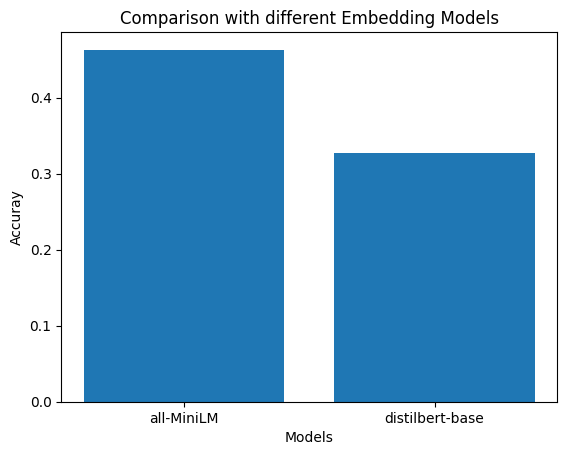

In [47]:
import matplotlib.pyplot as plt

values = [pipeline1_mean_value, pipeline2_mean_value]
labels = ['all-MiniLM', 'distilbert-base']

plt.bar(labels, values)

plt.title('Comparison with different Embedding Models')
plt.xlabel('Models')
plt.ylabel('Accuray')

plt.show()

##Pipeline 3




*   Embedding model = *distilbert-base-nli-stsb-mean-tokens*
*   Reranking model = *cross-encoder/ms-marco-MiniLM-L-6-v2*


In [39]:
ndcg_values = []


for i in range(0,len(all_questions)):
  ques_embedding_large = large_model.encode(all_questions[i], device='cuda')
  most_similar_answers = get_most_similar_answers(ques_embedding_large,all_answers_embeddings_large,all_answers,20)
  reranked_passages = rerank_docs(all_questions[i],most_similar_answers,model_name = 'cross-encoder/ms-marco-MiniLM-L-6-v2')
  relevant_passages = get_relevant_passages(i)
  relevance = [1 if ans in relevant_passages else 0 for ans in reranked_passages]
  k = 10
  ndcg_values.append(ndcg(relevance, relevance, k))


In [40]:
pipeline3_mean_value = np.mean(ndcg_values)
pipeline3_mean_value

0.41651327771630037

##Pipeline 4




*   Embedding model = *distilbert-base-nli-stsb-mean-tokens*
*   Reranking model = *efederici/cross-encoder-bert-base-stsb*


In [42]:
ndcg_values = []


for i in range(0,len(all_questions)):
  ques_embedding_large = large_model.encode(all_questions[i], device='cuda')
  most_similar_answers = get_most_similar_answers(ques_embedding_large,all_answers_embeddings_large,all_answers,20)
  reranked_passages = rerank_docs(all_questions[i],most_similar_answers,model_name = 'efederici/cross-encoder-bert-base-stsb')
  relevant_passages = get_relevant_passages(i)
  relevance = [1 if ans in relevant_passages else 0 for ans in reranked_passages]
  k = 10
  ndcg_values.append(ndcg(relevance, relevance, k))

In [43]:
pipeline4_mean_value = np.mean(ndcg_values)
pipeline4_mean_value

0.3104511870912487

#Comparison with and without Rerankers

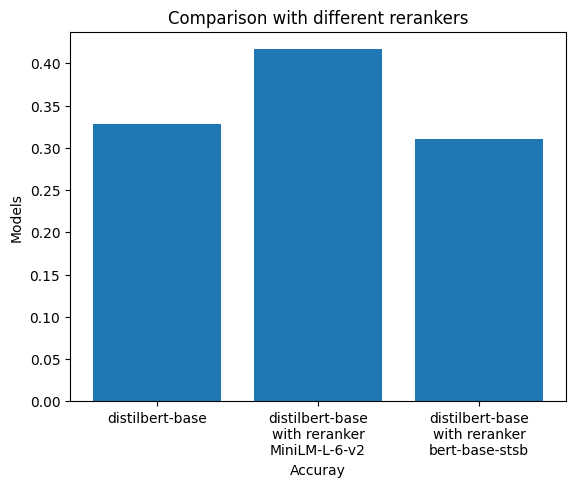

In [46]:
import matplotlib.pyplot as plt

values = [pipeline2_mean_value, pipeline3_mean_value,pipeline4_mean_value]
labels = ['distilbert-base','distilbert-base\nwith reranker\nMiniLM-L-6-v2','distilbert-base\nwith reranker\nbert-base-stsb']

plt.bar(labels, values)

plt.title('Comparison with different rerankers')
plt.xlabel('Accuray')
plt.ylabel('Models')

plt.show()